In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py, os, tqdm, glob
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.49'
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import optax
from flax import nnx
import orbax.checkpoint as ocp

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from jaxpm.painting import cic_paint, cic_read, compensate_cic
from jaxpm.utils import power_spectrum
from jaxpm.utils import _initialize_pk
from jaxpm.pm import linear_field, lpt, make_ode_fn, pm_forces
from jaxpm.kernels import fftk, gradient_kernel, invlaplace_kernel, longrange_kernel, invnabla_kernel
from jaxpm.nn import MLP
from jaxpm import camels

jax.devices("gpu")

[cuda(id=0)]

In [3]:
parts_per_dim = 64
mesh_per_dim = parts_per_dim
mesh_shape = [mesh_per_dim] * 3

In [5]:
# SIM = "/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_0"
SIM = "/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_1"

out_dict = camels.load_CV_snapshots(
    SIM,
    mesh_per_dim,
    parts_per_dim,
    i_snapshots=[-1],
)

Using snapshots ['/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_1/snapshot_090.hdf5']
Selecting 262144 dark matter (deterministic)
Selecting 262144 gas particles (random)


loading snapshots: 100%|██████████| 1/1 [00:11<00:00, 11.35s/it]


In [23]:
# vmap over the snapshots
# vcic_paint = jax.vmap(cic_paint, in_axes=(None,0,None))
# vcic_read = jax.vmap(cic_read, in_axes=(0,0))

vcic_paint = cic_paint
vcic_read = cic_read

def preprocess(snapshot_dict):
    cosmo = snapshot_dict["cosmo"]
    scales = snapshot_dict["scales"]
    gas_P = snapshot_dict["gas_Ps"]
    
    # rho (exactly like in PM)
    rho_dm = vcic_paint(jnp.zeros(mesh_shape), snapshot_dict["dm_poss"], None)
    rho_gas = vcic_paint(jnp.zeros(mesh_shape), snapshot_dict["gas_poss"], cosmo.Omega_b / cosmo.Omega_c)
    rho = rho_dm + rho_gas
    gas_rho = vcic_read(rho, snapshot_dict["gas_poss"])
    
    # fscalar
    kvec = fftk(mesh_shape)
    delta_k = jax.vmap(jnp.fft.rfftn, in_axes=0)(rho)
    fscalar = jax.vmap(jnp.fft.irfftn, in_axes=0)(delta_k * invnabla_kernel(kvec))
    gas_fscalar = vcic_read(fscalar, snapshot_dict["gas_poss"])

    return scales, rho, gas_rho, fscalar, gas_fscalar, gas_P

In [24]:
scales, rho, gas_rho, fscalar, gas_fscalar, gas_P = preprocess(out_dict)

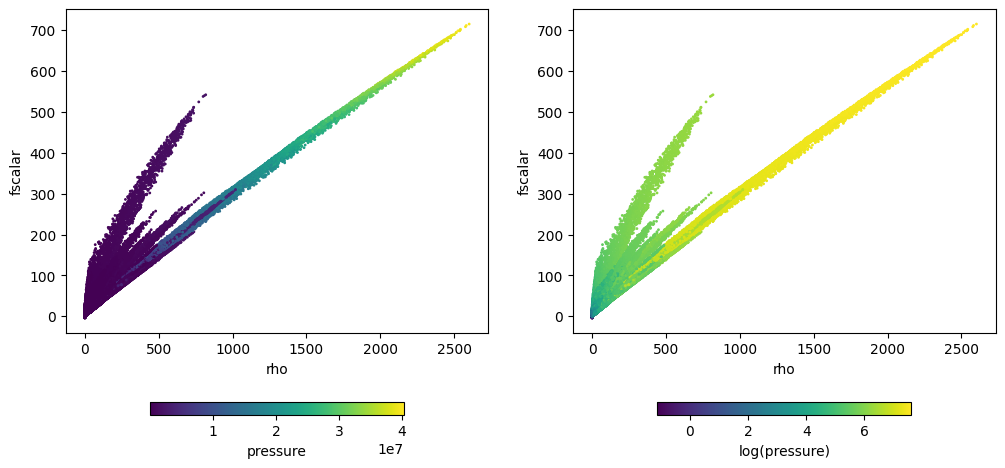

In [36]:
fig, ax = plt.subplots(figsize=(2*6,6), ncols=2, sharey="col")

im = ax[0].scatter(gas_rho, gas_fscalar, s=1, c=gas_P)
ax[0].set(xlabel="rho", ylabel="fscalar")
fig.colorbar(im, ax=ax[0], label="pressure", orientation="horizontal", shrink=0.6, aspect=20)

im = ax[1].scatter(gas_rho, gas_fscalar, s=1, c=jnp.log10(gas_P))
ax[1].set(xlabel="rho", ylabel="fscalar")
fig.colorbar(im, ax=ax[1], label="log(pressure)", orientation="horizontal", shrink=0.6, aspect=20)